Let us look at how we can implement text classification with Tensorflow https://www.tensorflow.org/
TensorFlow is an end-to-end open source platform for machine learning. 
The dataset is from the Tweet Sentiment Extraction challenge from Kaggle(https://www.kaggle.com/c/tweet-sentiment-extraction/overview)
We would implement text classification using a simple convolutional network developed using Tensorflow on tweet data to classify tweets as "positive","negative" or "neutral"

In [24]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

import tensorflow_hub as hub


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pydot
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
print(tf.__version__)
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)

2.9.2


In [26]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Please install GPU version of TF


Let us define methods to pre-process the tweets

In [27]:
df = pd.read_csv("mtsamples.csv")
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [28]:
df=df[['transcription','medical_specialty']]
df.head()

,transcription,medical_specialty
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Bariatrics
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",Bariatrics
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary


In [29]:
df = df[df['medical_specialty'] != ' Surgery']
df = df[df['medical_specialty'] != ' SOAP / Chart / Progress Notes']
df = df[df['medical_specialty'] != ' Emergency Room Reports']
df = df[df['medical_specialty'] != ' Discharge Summary']
df = df[df['medical_specialty'] != ' Office Notes']
df = df[df['medical_specialty'] != ' General Medicine']
df = df[df['medical_specialty'] != ' Pain Management']

In [30]:
df.isna().sum()

transcription        16
medical_specialty     0
dtype: int64

In [31]:
df.dropna(axis=0,inplace=True)

In [32]:
counts = df['medical_specialty'].value_counts()

df = df[~df['medical_specialty'].isin(counts[counts < 240].index)]
df.head()

,transcription,medical_specialty
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary
7,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",Cardiovascular / Pulmonary
9,"DESCRIPTION:,1. Normal cardiac chambers size....",Cardiovascular / Pulmonary
11,"2-D STUDY,1. Mild aortic stenosis, widely calc...",Cardiovascular / Pulmonary


In [33]:
special_character_remover = re.compile('[/(){}\[\]\|@,;]')
extra_symbol_remover = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [34]:
def clean_text(text):
    text = text.lower()
    text = special_character_remover.sub(' ',text)
    text = extra_symbol_remover.sub('',text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    for sentence in sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))    
    return ' '.join(wordlist) 

In [35]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [36]:
df['transcription'] = df['transcription'].apply(clean_text)
df['transcription'] = df['transcription'].apply(lemmatize_text)

In [37]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75,min_df=5, use_idf=True, smooth_idf=True,sublinear_tf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(df['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names())
del feature_names[0:35]
print(feature_names)

['60', '6french', '70', '75', '80', '90', '92', '93', '95', '96', 'abc', 'abcd', 'abdomen', 'abdomen soft', 'abdomen soft nontender', 'abdominal', 'abdominal pain', 'able', 'abnormal', 'abnormality', 'abuse', 'according', 'achieved', 'active', 'activity', 'acute', 'acute distress', 'addition', 'additional', 'adenopathy', 'adequate', 'administered', 'admission', 'admitted', 'advanced', 'affect', 'age', 'ago', 'air', 'airway', 'alcohol', 'alert', 'alert oriented', 'allergic', 'allergy', 'allergy known', 'allergy known drug', 'anemia', 'anesthesia', 'anesthesia general', 'anesthetic', 'angiogram', 'angiography', 'ankle', 'anterior', 'anterior descending', 'antibiotic', 'anxiety', 'aorta', 'aortic', 'aortic valve', 'ap', 'apparently', 'appear', 'appearance', 'appeared', 'appears', 'applied', 'appropriate', 'approximately', 'area', 'arm', 'arterial', 'artery', 'artery disease', 'arthritis', 'asked', 'aspect', 'aspirin', 'assessment', 'associated', 'atraumatic', 'atrial', 'atrial fibrillatio

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
#Principal component analysis (PCA).
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = df['medical_specialty'].tolist()
category_list = df.medical_specialty.unique()

In [39]:
print(df['medical_specialty'])

3        Cardiovascular / Pulmonary
4        Cardiovascular / Pulmonary
7        Cardiovascular / Pulmonary
9        Cardiovascular / Pulmonary
11       Cardiovascular / Pulmonary
                   ...             
4972     Cardiovascular / Pulmonary
4973     Cardiovascular / Pulmonary
4974     Cardiovascular / Pulmonary
4975     Cardiovascular / Pulmonary
4976     Cardiovascular / Pulmonary
Name: medical_specialty, Length: 1515, dtype: object


In [40]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_url(text): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string



def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()



Let us split the training data into train and validation datasets
Let us convert our training,validation and test data into the format accepted by tensorflow

***
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
<br>
This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...
***

In [41]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(df['medical_specialty'].tolist())
print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

   


[[1, 1, 1, 1]]


In [42]:
X_train, X_valid, y_train, y_valid = train_test_split(df['transcription'].tolist(), df['medical_specialty'].tolist(),  stratify = df['medical_specialty'].tolist(), test_size=0.1,random_state=0)
x_train=np.array(tokenizer.texts_to_sequences(X_train))
x_valid =np.array(tokenizer.texts_to_sequences(X_valid))
#This class allows to vectorize a text corpus, by turning each text 
#into either a sequence of integers
x_test =np.array(tokenizer.texts_to_sequences(df['transcription'].tolist()))
x_train = pad_sequences(x_train, padding='post', maxlen=40)
x_valid = pad_sequences(x_valid, padding='post', maxlen=40)
x_test = pad_sequences(x_test, padding='post', maxlen=40)
le = LabelEncoder() #Convert text category into numbers
train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#convert to categorical values 1 0 0 0, ...
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))
test_labels = le.transform(df['medical_specialty'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
#creating tensorflow dataset by concatenating sequences and perspective labels 
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((df['medical_specialty'],test_labels))


<ipython-input-42-d9d6b96ca4c0>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train=np.array(tokenizer.texts_to_sequences(X_train))
<ipython-input-42-d9d6b96ca4c0>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_valid =np.array(tokenizer.texts_to_sequences(X_valid))
<ipython-input-42-d9d6b96ca4c0>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when cr

In [43]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

[' Consult - History and Phy.', ' Cardiovascular / Pulmonary', ' Cardiovascular / Pulmonary', ' Consult - History and Phy.', ' Cardiovascular / Pulmonary', ' Cardiovascular / Pulmonary', ' Consult - History and Phy.', ' Radiology', ' Cardiovascular / Pulmonary', ' Consult - History and Phy.']
Text to number
[1 0 0 1 0 0 1 3 0 1]
Number to category
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


Let us create a simple Convolutional Neural Network model  
<br>
<br>
Keras is a high-level API that's easier for ML beginners, as well as researchers.
It is integrated as part of Tensorflow 2.0
<br>
I am using the Sequential model
A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
Source :https://www.tensorflow.org/guide/keras/sequential_model
***

In [44]:
# max_features =20000    #The number of the words
# embedding_dim =64       #Embedding Layers to convrting indexx values to embeding dimension so the embedding dimension is 64.
# #basicall indexes introduce by 64 dimensional vectors
# sequence_length = 40    #It is for forty indexes
# model = tf.keras.Sequential()
# # the output is embedding dimension vectors
# model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
#                                     embeddings_regularizer = regularizers.l2(0.0004)) 
# #Below we add convoloutional neural network layer: 
# #128 = convoloutional filters  


# model.add(tf.keras.layers.Conv1D(128, 3, activation='relu',kernel_regularizer = regularizers.l2(0.0004),\
#                                  bias_regularizer = regularizers.l2(0.0004)))                       


# #Then we have GlobalMaxPooling                  
# model.add(tf.keras.layers.GlobalMaxPooling1D())
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(3, activation='sigmoid',\
#                                 kernel_regularizer=regularizers.l2(0.004),\
#                                 bias_regularizer=regularizers.l2(0.004),))
# #dense =3 = layers and classes    # regularization would prevent overfitting            
# model.summary()
# # We use CategoricalCrossentropyas loss function
# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])

In [45]:
max_features =20000
embedding_dim =64
sequence_length = 40

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0004)))                                    

model.add(tf.keras.layers.Conv1D(128,4, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0004),\
                                 bias_regularizer = regularizers.l2(0.0004)))                               


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(4, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.004),\
                                bias_regularizer=regularizers.l2(0.004),))
                               



model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 64)            1280064   
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 128)           32896     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 1,313,476
Trainable params: 1,313,476
Non-trainable params: 0
____________________________________________

![Conv1.png](attachment:Conv1.png)

![Conv2.png](attachment:Conv2.png)

![Conv3.png](attachment:Conv3.png)

![Conv4.png](attachment:Conv4.png)

![Conv5.png](attachment:Conv5.png)

Let's train our model

In [46]:
epochs = 100
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


11/11 [==============================] - 2s 76ms/step - loss: 1.7766 - categorical_accuracy: 0.3133 - val_loss: 1.6709 - val_categorical_accuracy: 0.3421
Epoch 2/100
11/11 [==============================] - 1s 53ms/step - loss: 1.6073 - categorical_accuracy: 0.3404 - val_loss: 1.5393 - val_categorical_accuracy: 0.3421
Epoch 3/100
11/11 [==============================] - 1s 57ms/step - loss: 1.4977 - categorical_accuracy: 0.3419 - val_loss: 1.4647 - val_categorical_accuracy: 0.3421
Epoch 4/100
11/11 [==============================] - 1s 52ms/step - loss: 1.4382 - categorical_accuracy: 0.3397 - val_loss: 1.4273 - val_categorical_accuracy: 0.3421
Epoch 5/100
11/11 [==============================] - 1s 54ms/step - loss: 1.4071 - categorical_accuracy: 0.3456 - val_loss: 1.4108 - val_categorical_accuracy: 0.3421
Epoch 6/100
11/11 [==============================] - 1s 52ms/step - loss: 1.3935 - categorical_accuracy: 0.3485 - val_loss: 1.4045 - val_categorical_accuracy: 0.3421
Epoch 7/100
11/1

In [47]:
history.history


{'loss': [1.7765593528747559,
  1.6072626113891602,
  1.497699499130249,
  1.4382412433624268,
  1.4071273803710938,
  1.3935089111328125,
  1.3834033012390137,
  1.3759187459945679,
  1.37211012840271,
  1.3659766912460327,
  1.3631277084350586,
  1.3616375923156738,
  1.3603192567825317,
  1.360921025276184,
  1.3561069965362549,
  1.354892611503601,
  1.3501561880111694,
  1.3484889268875122,
  1.3498387336730957,
  1.3494583368301392,
  1.3464306592941284,
  1.3471792936325073,
  1.3485350608825684,
  1.348105788230896,
  1.3442400693893433,
  1.3429949283599854,
  1.344367265701294,
  1.343490719795227,
  1.3405449390411377,
  1.343953251838684,
  1.3459454774856567,
  1.3409889936447144,
  1.343921184539795,
  1.3408111333847046,
  1.3404924869537354,
  1.3394997119903564,
  1.3409314155578613,
  1.3442133665084839,
  1.3397681713104248,
  1.3398267030715942,
  1.3402819633483887,
  1.3404744863510132,
  1.338462233543396,
  1.3352333307266235,
  1.3369094133377075,
  1.334722161

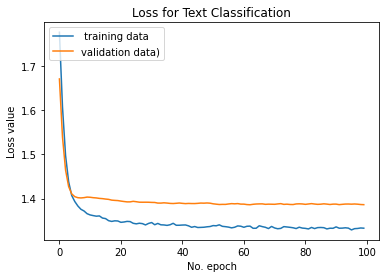

In [48]:

plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

Lets save our model and tokenizer

In [49]:
model.save('C:/Users/Samira/pro') 
json_string = tokenizer.to_json()

In [50]:
import json
with open('C:/Users/Samira/pro/tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)

Lets load our model and test on test data

In [51]:
new_model = tf.keras.models.load_model('C:/Users/Samira/pro')
new_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 64)            1280064   
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 128)           32896     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 1,313,476
Trainable params: 1,313,476
Non-trainable params: 0
____________________________________________

In [52]:
with open('C:/Users/Samira/pro/tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

In [53]:
x_test  = np.array( tokenizer1.texts_to_sequences(df['medical_specialty'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=40)

<ipython-input-53-387e083bc6c6>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test  = np.array( tokenizer1.texts_to_sequences(df['medical_specialty'].tolist()) )


In [54]:

# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)


Generate predictions for all samples
48/48 [==============================] - 0s 4ms/step
[[0.534976   0.4781028  0.44742724 0.5321581 ]
 [0.534976   0.4781028  0.44742724 0.5321581 ]
 [0.534976   0.4781028  0.44742724 0.5321581 ]
 ...
 [0.534976   0.4781028  0.44742724 0.5321581 ]
 [0.534976   0.4781028  0.44742724 0.5321581 ]
 [0.534976   0.4781028  0.44742724 0.532158  ]]


In [55]:
df['pred_medical_specialty']= predict_results

df['pred_medical_specialty'] = np.where((df.pred_medical_specialty ==  0), ' Cardiovascular / Pulmonary',df.pred_medical_specialty)

df['pred_medical_specialty'] = np.where((df.pred_medical_specialty == '1'),' Consult - History and Phy.',df.pred_medical_specialty)
df['pred_medical_specialty'] = np.where((df.pred_medical_specialty == '2'),' Orthopedic',df.pred_medical_specialty)
df['pred_medical_specialty'] = np.where((df.pred_medical_specialty == '3'),' Radiology',df.pred_medical_specialty)


In [56]:
df

,transcription,medical_specialty,pred_medical_specialty
3,2d mmode 1 left atrial enlargement left atrial...,Cardiovascular / Pulmonary,Cardiovascular / Pulmonary
4,1 left ventricular cavity size wall thickness ...,Cardiovascular / Pulmonary,Cardiovascular / Pulmonary
7,2d echocardiogram multiple view heart great ve...,Cardiovascular / Pulmonary,Cardiovascular / Pulmonary
9,description 1 normal cardiac chamber size 2 no...,Cardiovascular / Pulmonary,Cardiovascular / Pulmonary
11,2d study 1 mild aortic stenosis widely calcifi...,Cardiovascular / Pulmonary,Cardiovascular / Pulmonary
...,...,...,...
4972,indication chest pain type test adenosine nucl...,Cardiovascular / Pulmonary,Cardiovascular / Pulmonary
4973,chief complaint chest pain history present ill...,Cardiovascular / Pulmonary,Cardiovascular / Pulmonary
4974,history present illness patient 68yearold woma...,Cardiovascular / Pulmonary,Cardiovascular / Pulmonary
4975,history present illness mr abc 60yearold gentl...,Cardiovascular / Pulmonary,Cardiovascular / Pulmonary


In [57]:
from sklearn.metrics import classification_report  
print(classification_report(df['medical_specialty'],df['pred_medical_specialty']))

                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       1.00      1.00      1.00       371
 Consult - History and Phy.       0.65      1.00      0.79       516
                 Orthopedic       1.00      1.00      1.00       355
                  Radiology       0.00      0.00      0.00       273

                   accuracy                           0.82      1515
                  macro avg       0.66      0.75      0.70      1515
               weighted avg       0.70      0.82      0.75      1515



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
